In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import torch
import os
from CIA.getters import get_handler, get_data_processor, \
    get_dataloader_generator, get_decoder, get_positional_embedding,\
    get_sos_embedding
# from CIA.handlers.decoder_events_handler import 
import time
import importlib
from CIA.positional_embeddings.positional_embedding import PositionalEmbedding
from torch.nn.parallel import DistributedDataParallel
import einops
from CIA.utils import get_free_port
from CIA.data_processors.data_processor import DataProcessor
from CIA.handlers.decoder_events_handler import DecoderEventsHandler
import numpy as np
import matplotlib.pyplot as plt
import functools
from pathlib import Path
import miditoolkit
import pretty_midi

In [3]:
GPU = 0
rank = GPU
world_size = 1
rank = 0
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = str(get_free_port())
if torch.cuda.is_available() and GPU in list(range(4)):
    torch.distributed.init_process_group(backend="nccl", world_size=world_size, rank=rank)
    torch.cuda.set_device(rank)
    device_ids = [rank]
    output_device = rank
    device = f"cuda:{rank}"
else:
    # cpu case
    torch.distributed.init_process_group(backend="gloo", world_size=world_size, rank=rank)
    device_ids = None
    output_device = None
    device = "cpu"


In [4]:
model_dir = 'models/piano_event_performer_2021-10-01_16:03:06'
# config =  importlib.import_module('CIA.configs.piarceiverStack').config
# NOTE: override configuration
config = importlib.import_module('.config_autoreg', f'{model_dir.replace("/", ".")}').config
for t in ['time_dilation', 'velocity_shift', 'transposition']:
    config['dataloader_generator_kwargs']['transformations'][t] = False
config['data_processor_kwargs']['num_events_before'] = 1
config['data_processor_kwargs']['num_events_after'] = 0
# TODO: check correct number...
num_events_middle = 1024 - 6
num_max_generated_events = 1024 - 6

load = True
overfitted = True

# === Decoder ====
# dataloader generator
dataloader_generator = get_dataloader_generator(
    dataset=config["dataset"],
    dataloader_generator_kwargs=config["dataloader_generator_kwargs"],
)

# data processor
data_processor: DataProcessor = get_data_processor(
    dataloader_generator=dataloader_generator,
    data_processor_type=config["data_processor_type"],
    data_processor_kwargs=config["data_processor_kwargs"],
)

# positional embedding
positional_embedding: PositionalEmbedding = get_positional_embedding(
    dataloader_generator=dataloader_generator,
    positional_embedding_dict=config["positional_embedding_dict"],
)

# sos embedding
sos_embedding = get_sos_embedding(
    dataloader_generator=dataloader_generator,
    sos_embedding_dict=config["sos_embedding_dict"],
)

decoder = get_decoder(
    data_processor=data_processor,
    dataloader_generator=dataloader_generator,
    positional_embedding=positional_embedding,
    sos_embedding=sos_embedding,
    decoder_kwargs=config["decoder_kwargs"],
    training_phase=False,
    handler_type=config["handler_type"],
)

decoder.to(device)
decoder = DistributedDataParallel(
    module=decoder,
    device_ids=[rank] if GPU is not None else None,
    output_device=rank
    # )
    ,
    find_unused_parameters=True,
)

decoder_handler = get_handler(
    handler_type=config["handler_type"],
    decoder=decoder,
    model_dir=model_dir,
    dataloader_generator=dataloader_generator,
)

if load:
    if overfitted:
        decoder_handler.load(early_stopped=False)
    else:
        decoder_handler.load(early_stopped=True)

if hasattr(decoder_handler.model.module.transformer, "fix_projection_matrices_"):
    decoder_handler.model.module.transformer.fix_projection_matrices_()



Loading index dictionnary
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will

In [5]:
# Load a piece (for inpainting)
# null_superconditioning = [1, 1.5, 2, 2.5]


# (_, generator_val, _) = dataloader_generator.dataloaders(
#     batch_size=1, num_workers=num_workers, shuffle_val=True
# )
# original_x = next(generator_val)["x"]
piece = 'Bach, Carl Philipp Emanuel, Keyboard Sonata in F major, H.55, zRPTf8eGLWc'
# {-63, -53, ..., -3, 7, ... }
start_time = -3
for split, samples in  dataloader_generator.dataset.list_ids.items():
    for id_, sample in enumerate(samples):
        if piece == sample['score_name'] and start_time == sample['start_time']:
            break
    else:
        continue
    break
dataloader_generator.dataset.split = split
data = dataloader_generator.dataset[id_]
original_x = torch.stack([data[e] for e in dataloader_generator.features], dim=-1)[None]
# NOTE: num_events_middle likely the number of notes which will be created? Actually more events are created...
# NOTE: first event is always the same, probably because it's a special start token, .
# NOTE: Num events, most likely, defines the event (after decode start) that should be how long time (in the original score) we should we should generate. 
# TODO: what's the difference between num_events_middle and num_max_generated_events? Probably 
# Only needed for setting up start_decode and end_decode.
# Does the model actually actually not attend to the after (future) tokens while decoding? 
# Actually preprocess should return (shuffle the data): 
# before  middle  after -> before  placeholder  after  SOD (start of decoding)  middle  END XX XX (pad)
# NOTE: metadata_dict['decoding_end'] is not used for inpaint_non_optimized 

x, metadata_dict = data_processor.preprocess(original_x, num_events_middle=num_events_middle)

In [ ]:
# "open ended"
secs_dec = 25.
batch_size = 1
placeholder, placeholder_duration_token = data_processor.compute_placeholder(placeholder_duration=torch.tensor([secs_dec]), batch_size=batch_size)
before = einops.repeat(data_processor.start_tokens, 'd ->b 1 d', b=batch_size)
after = torch.empty(batch_size, 0, placeholder.shape[-1], dtype=torch.long, device=device)
sod =  einops.repeat(data_processor.start_tokens, 'd ->b 1 d', b=batch_size)
query = torch.cat([before, placeholder, after, sod], dim=1)
middle = torch.zeros(batch_size, num_events_middle-1, placeholder.shape[-1], dtype=torch.long, device=device)
end = einops.repeat(data_processor.end_tokens, 'd ->b 1 d', b=batch_size)
padding_len = config['dataloader_generator_kwargs']['sequences_size'] - query.shape[1] - middle.shape[1] - 1
padding = einops.repeat(data_processor.end_tokens, 'd ->b padding d', b=batch_size, padding=padding_len)
x = torch.cat([
    query,
    middle,
    end, 
    padding,

],
axis=1)
metadata_dict = {
    'placeholder_duration': torch.tensor([secs_dec], device=device),
    'decoding_start': query.shape[1],
    # 'decoding_end': query.shape[1] - 1+  num_events_middle,
}

In [7]:
# NOTE: with current setup this corresponds to open ended generation.
# [START]  placeholder (programs the model to decode until a certain total time, where the end note is produced)  []  SOD  [m0,m1,...,m9]  END XX XX
# NOTE: loss_mask is not used in inpainting, how do we handle attention mask?
# metadata_dict.pop('loss_mask')
# metadata_dict['decoding_start'] = 0
# metadata_dict['decoding_end'] = 1024
start_time = time.time()
# NOTE: Here it always attends (!autoregressively!) to full sequence but updates during (autoregressive) decoding.
# NOTE: model decodes from decode start and decode up to the next num_events_middle. 
# If at one time the placeholder_duration is exceeded, or END symbol, then it terminates with done.
# Otherwise it terminates after resampling all events in "middle".

# NOTE: When generating all channels of a note, the prob is not autoreg, instead the state of previous note is computed, 
# and the model is "programed" to generate a certain token in the head, by appending previous computed embeddings to he state
# 
#  If it did not . We can probably fix this 
# by giving a sequence of some mask token, from the beginning. 
ts = torch.arange(0.5, 10, .5)
(
    temp,
    gen
) = decoder_handler.inpaint_ic_curve(
    x=x.clone(),
    interpolation_time_points=ts,
    k_traces=128,
    weight_fn=DecoderEventsHandler.mov_avg,
    metadata_dict=metadata_dict,
    temperature=1.0,
    top_p=1.0,
    top_k=0,
    num_max_generated_events=num_max_generated_events
)
end_time = time.time()

# x_inpainted = torch.cat([before, generated_region, after, end], axis=1)
# x_inpainted = data_processor.postprocess(x_gen, decoding_end, metadata_dict)
# x_inpainted_orig = data_processor.postprocess(original_x, decoding_end, metadata_dict)
# print(f"Time of generated sequence {dataloader_generator.get_elapsed_time(x_inpainted[0][None])[0,-1]}")
# dataloader_generator.write(x_inpainted_orig[0], 'out/orig')
x_inpainted = data_processor.postprocess(gen.tok[None], gen.decoding_end, metadata_dict)
dataloader_generator.write(x_inpainted[0], 'out/inpainted_seq_ics')

Placeholder duration: tensor([104.1000], device='cuda:0')


/share/hel/home/mathias/devel/python3/PIA.No3/CIA/handlers/decoder_events_handler.py:615: UserWarning: Check that metadata_dict is correctly used...
  warn('Check that metadata_dict is correctly used...')


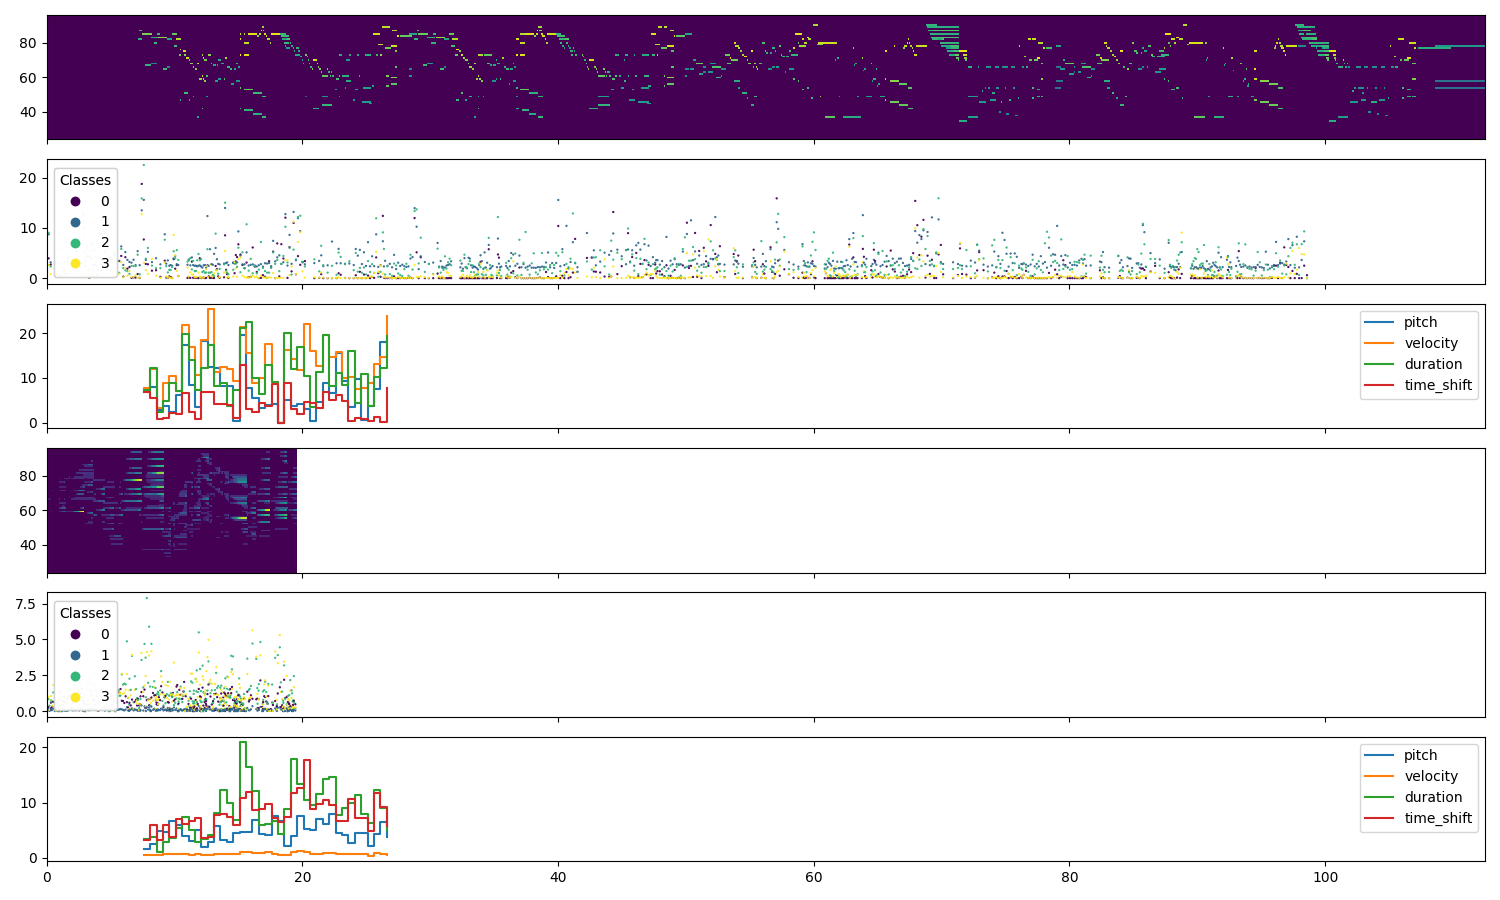

In [57]:
files = [f'/home/mathias/.cache/mutdata/pia/databases/Piano/transcriptions/midi/{piece}.mid', 'out/inpainted_seq_ics.mid']
res = [temp, gen]
first_time = True

fig, ax = plt.subplots(len(files) * 3, 1, figsize=(15,9), sharex=True)
for i, (f, r) in enumerate(zip(files, res)):
    midi2 = pretty_midi.PrettyMIDI(f)
    first_onset = min([n.start for n in  midi2.instruments[0].notes])
    for note in midi2.instruments[0]:
        note.start -= first_onset
        note.end -= first_onset
    sr = 10
    pr2 = midi2.get_piano_roll(sr).T
    end = pr2.shape[0]/sr


    legends = dataloader_generator.features
    bs = 2

    nr = (24,96)
    # nr = (None, None)
    ax[i *3 + 0].imshow(pr2.T[slice(*nr)], origin='lower',extent=[0, end, *nr],aspect='auto', interpolation='none')
    # if first_time:
    #     start = pr2.any(1).argmax()/sr
    #     first_time = False

    channels = slice(0, 4)
    n_channels = channels.stop- channels.start
    unique_timepoints, cum_ics = DecoderEventsHandler.unique_timepoints(r.timepoints, r.ic_tok[metadata_dict['decoding_start']:r.decoding_end])
    n_points = len(unique_timepoints)
    # ax[1].plot(unique_timepoint, cum_ics[:, channel],'.-')
    c = np.broadcast_to(np.arange(n_channels)[None,:], (n_points, n_channels)).flatten()

    times = np.broadcast_to(np.array(unique_timepoints)[:,None], (n_points, n_channels)).flatten()
    scatter = ax[i*3+1].scatter(
        times,
        cum_ics[:, channels].numpy().flatten(),
        c=c,
        s=1.5,
        marker='.'
    )
    legend1 = ax[i*3+1].legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax[i*3+1].add_artist(legend1)

    # produce a legend with a cross-section of sizes from the scatter
    # handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    # legend2 = ax[1].legend(handles, labels, loc="upper right", title="Sizes")


    ax[i*3+2].step(ts, r.ic_int[:, channels], where='post')
    ax[i*3+2].legend(legends[channels])

    fig.tight_layout()


    # fig.show()

In [ ]:
plt.savefig('ic_curve.pdf')